In [ ]:
# import os
# os.environ['LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] = '/home/apanin/cuda-8.0/lib64'
# os.environ['PATH'] = "/usr/local/cuda-8.0/bin/:/home/apanin/cuda-8.0/lib64:"+os.environ['PATH']

In [ ]:
# %env THEANO_FLAGS=device=cuda0,gpuarray.preallocate=0.5,floatX=float32
# import theano
# import theano.tensor as T
# from lasagne import *
# from lasagne.layers import *

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [4]:
subsystemNames = ['L1tcalo', 'L1tmu', 'Hlt', 'Pix', 'Strip', 'Ecal', 'Hcal', 'Dt',
                    'Rpc', 'Es', 'Csc', 'Track', 'Egamma', 'Muon', 'Jetmet', 'Lumi']

In [5]:
Ids_labels = ['runId','lumiId','lumi','isSig']

In [6]:
file_name_merged = '/home/fedor/notebook/ml4dc/ok_files/merged.pickle'
data = pd.read_pickle(file_name_merged)

In [7]:
data = data.dropna(axis=0, how='any')

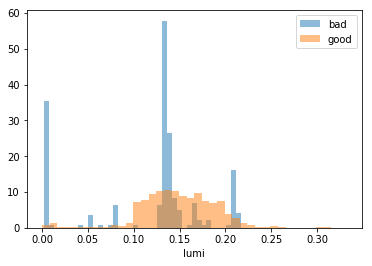

In [8]:
plt.hist(data["lumi"][data['isSig']==0], label = "bad", normed = True, alpha = 0.5, bins=40)#, range=(0.0,0.02))
plt.hist(data["lumi"][data['isSig']==1], label = "good", normed = True, alpha = 0.5, bins=40)#, range=(0.0,0.02))
plt.xlabel("lumi")
plt.legend()
plt.show()

In [9]:
data[data["lumi"]<0.01][data['isSig']==1][['runId','lumiId']]

/home/apanin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,runId,lumiId
229,275963,82
9772,281727,1245
9773,281727,1246
9774,281727,1247
9775,281727,1341
9776,281727,1401
9777,281727,1405
10154,281613,262
10155,281613,263
10156,281613,264


In [10]:
nonempty = np.where(data["lumi"] >= 0.01)[0]

In [11]:
data = data.iloc[nonempty]

In [12]:
features = [x for x in data.columns.get_values() if x not in subsystemNames+['runId','lumiId','isSig']]

In [13]:
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [14]:
labels = data["isSig"]
data_features = data[features]

In [15]:
np.mean(labels)

0.9799013678235787

In [16]:
data_features.shape

(10747, 750)

In [17]:
num_good = np.sum(labels)
num_bad = len(labels)-np.sum(labels)

In [18]:
weights = 0.5 / np.where(labels == 1.0, num_good, num_bad)
weights *= len(labels)

In [19]:
num_good, num_bad

(10531, 216)

In [20]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.1, random_state = 1)

In [21]:
y_train = np.array(labels.iloc[indx_train], 'float32')
y_test = np.array(labels.iloc[indx_test], 'float32')

X_train = np.array(data_features.iloc[indx_train], 'float32')
X_test = np.array(data_features.iloc[indx_test], 'float32')

weights_train = weights[indx_train]
weights_test = weights[indx_test]

In [22]:
len(y_test)-np.sum(y_test)

22.0

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score,recall_score, confusion_matrix

In [24]:
from sklearn.model_selection import GridSearchCV,cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [25]:
names = ["LogisticRegression", 
         "RBF SVM", 
         "Random Forest",  
         "AdaBoost",
         "Naive Bayes"]

classifiers = [
    LogisticRegression(penalty= 'l1', C=0.02),
    SVC(kernel='rbf', C=100, gamma=0.001, probability=True),
    RandomForestClassifier(max_depth=15, n_estimators=40, max_leaf_nodes = 50, min_samples_leaf=5),
    AdaBoostClassifier(n_estimators=60),
    GaussianNB()]

LogisticRegression
confusion_matrix for train set
[[ 190    4]
 [ 850 8628]]
confusion_matrix for train set
[[ 19   3]
 [ 97 956]]
19 132
RBF SVM
confusion_matrix for train set
[[ 194    0]
 [   0 9478]]
confusion_matrix for train set
[[  13    9]
 [   1 1052]]
13 3
Random Forest
confusion_matrix for train set
[[ 194    0]
 [  16 9462]]
confusion_matrix for train set
[[  12   10]
 [   2 1051]]
13 9
AdaBoost
confusion_matrix for train set
[[ 194    0]
 [ 211 9267]]
confusion_matrix for train set
[[  15    7]
 [  25 1028]]
21 874
Naive Bayes
confusion_matrix for train set
[[ 175   19]
 [4470 5008]]
confusion_matrix for train set
[[ 19   3]
 [481 572]]
19 484


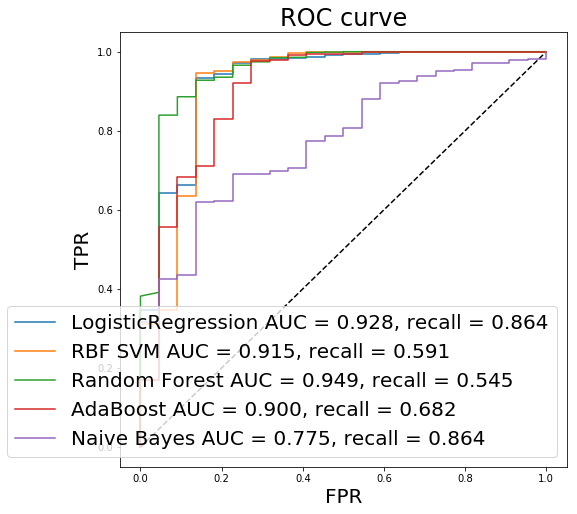

In [28]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train, sample_weight=weights_train)
    probas = clf.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, probas[:,1], sample_weight=weights_test)
    auc_score = roc_auc_score(y_test, probas[:,1])
    rec_score = recall_score(1-y_test, 1-np.round(probas[:,1]))
    plt.plot(fpr, tpr, label= name+' AUC = %.3lf' % auc_score+', recall = %.3lf' % rec_score)
    
    print name  
    print 'confusion_matrix for train set'
    print confusion_matrix(y_train, np.round(clf.predict_proba(X_train)[:,1]))
    print 'confusion_matrix for train set'
    print confusion_matrix(y_test, np.round(probas[:,1])) 
    print len(np.where(probas[:,1][y_test == 0] <= 0.6)[0]), len(np.where(probas[:,1][y_test == 1] <= 0.6)[0])
    
plt.legend(loc='lower right', fontsize=20)
plt.title('ROC curve', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

In [29]:
from sklearn import svm


# fit the model
clf = svm.OneClassSVM(nu = 0.05)
clf.fit(X_train[y_train == 1])
y_pred_train = clf.predict(X_train[y_train == 1])
y_pred_test = clf.predict(X_test[y_test == 1])
y_pred_outliers = clf.predict(np.vstack((X_test[y_test == 0],X_train[y_train == 0])))

In [30]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [31]:
y_pred_train[y_pred_train == 1].size, y_pred_test[y_pred_test == 1].size

(9003, 1007)

In [32]:
n_error_train 

475

In [33]:
n_error_test

46

In [34]:
n_error_outliers

180